In [16]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# utility imports
from utilities.processing_utility import get_q_2_cw_data, get_train_test_split

# strategies imports
from strategies.gp_prediction import *

# torch.manual_seed(69)
# np.random.seed(69)

# utility imports
from utilities.processing_utility import get_q_2_cw_data 
from utilities.processing_utility import get_train_test_split, get_moving_average

from utilities.plotting_utility import plot_price_and_returns, plot_strategy_positions, plot_pnl

from utilities.strategy_utilities import *

from utilities.performance_utilities import sharpe_ratio, sortino_ratio, max_drawdown, calmar_ratio

# strategy imports

from strategies.gp_prediction import *

from utilities.plotting_utility import save_to_gif

**Load the CW data**

In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


**Split the data**

In [3]:
split_idx = int(len(df) * 0.7)
excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_dict, test_dict = get_train_test_split(split_idx, R = excess_return_data, P = price_data, X = x_data)

r_train, r_test = train_dict['R'], test_dict['R']
p_train, p_test = train_dict['P'], test_dict['P']
x_train, x_test = train_dict['X'], test_dict['X']

**Plot the data**

Text(0.5, 1.0, 'S&P 500 normalised Excess Returns')

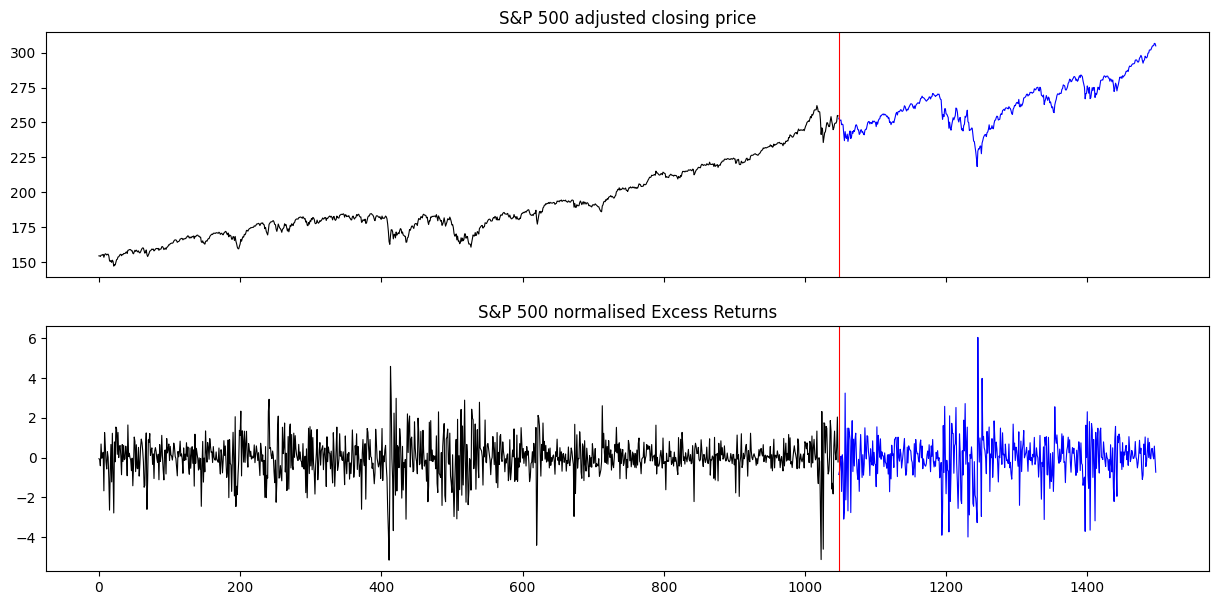

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 7))

# plot the original price series
ax1.plot(x_train, p_train, color = 'black', lw = 0.8, alpha = 1)
ax1.plot(x_test, p_test, color = 'blue', lw = 0.8, alpha = 1)
ax1.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax1.set_title('S&P 500 adjusted closing price')

# plot the normalised excess returns
ax2.plot(x_train, r_train, color = 'black', lw = 0.8, alpha = 1)
ax2.plot(x_test, r_test, color = 'blue', lw = 0.8, alpha = 1)
ax2.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax2.set_title('S&P 500 normalised Excess Returns')

**Find Optimal Linear GP Hyperparameters**

In [6]:
model = LinearGP(inputs = x_train, targets = p_train, likelihood = gp.likelihoods.GaussianLikelihood())
lengthscal_hat, noise_hat, weights_hat, bias_hat = optimise_marginal_likelihood(model)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
          1000          |   77.21798706054688    |        3.49273         |        2.01151         
----------------------------------------------------------------------------------------------------
          2000          |   38.33580780029297    |        4.74780         |        2.19152         
----------------------------------------------------------------------------------------------------
          3000          |   23.420473098754883   |        5.74456         |        2.29879         
----------------------------------------------------------------------------------------------------
          4000          |   15.35749340057373    |        6.62378         |        2.37138         
----------------------------------------------------------------------------------------------------
          5000          |   10.315503120422363   |        7.42375         |        2.41828      

In [7]:
linear_gp = get_linear_gp(x_train, p_train, lengthscal_hat, noise_hat, weights_hat, bias_hat)

In [8]:
x_star = get_x_star(x_train)

# get the posterior distribution
f_preds, f_preds_lower, f_preds_upper = linear_gp.get_posterior(x_star, confidenceregion = True)

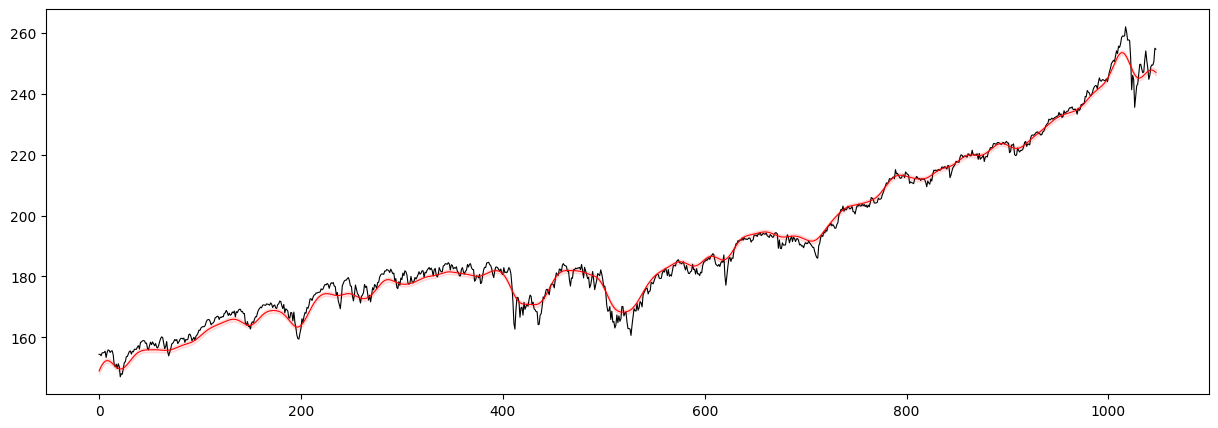

In [9]:
plt.plot(x_train, p_train, color = 'black', lw = 0.8, alpha = 1)
plt.plot(x_star, f_preds.mean , color = 'red', lw = 0.8, alpha = 1)
plt.fill_between(x_star, f_preds_lower, f_preds_upper, color = 'red', alpha=0.1)


In [10]:
# traing GP
train_linear_gp = get_linear_gp(x_train, p_train, lengthscal_hat, noise_hat, weights_hat, bias_hat)
train_f_preds, train_f_preds_lower, train_f_preds_upper = train_linear_gp.get_posterior(x_train, confidenceregion = True)

# test GP
test_linear_gp = get_linear_gp(x_test, p_test, lengthscal_hat, noise_hat, weights_hat, bias_hat)
test_f_preds, test_f_preds_lower, test_f_preds_upper = test_linear_gp.get_posterior(x_test, confidenceregion = True)

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Text(0.5, 1.0, 'Training Data')

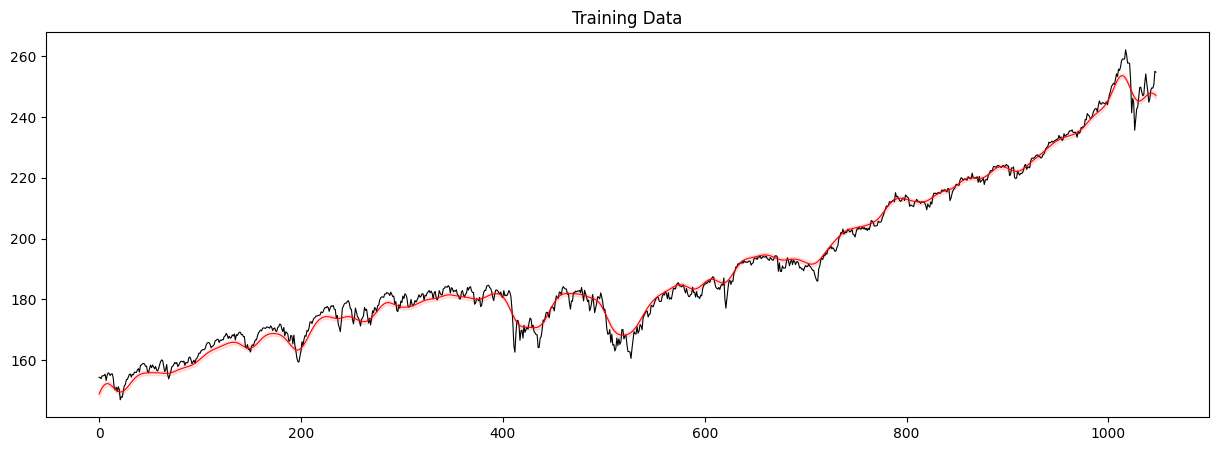

In [11]:
plt.plot(x_train, p_train, color = 'black', lw = 0.8, alpha = 1)
plt.plot(x_train, train_f_preds.mean , color = 'red', lw = 0.8, alpha = 1)
plt.fill_between(x_train, train_f_preds_lower, train_f_preds_upper, color = 'red', alpha=0.1)
plt.title('Training Data')

Text(0.5, 1.0, 'Testing Data')

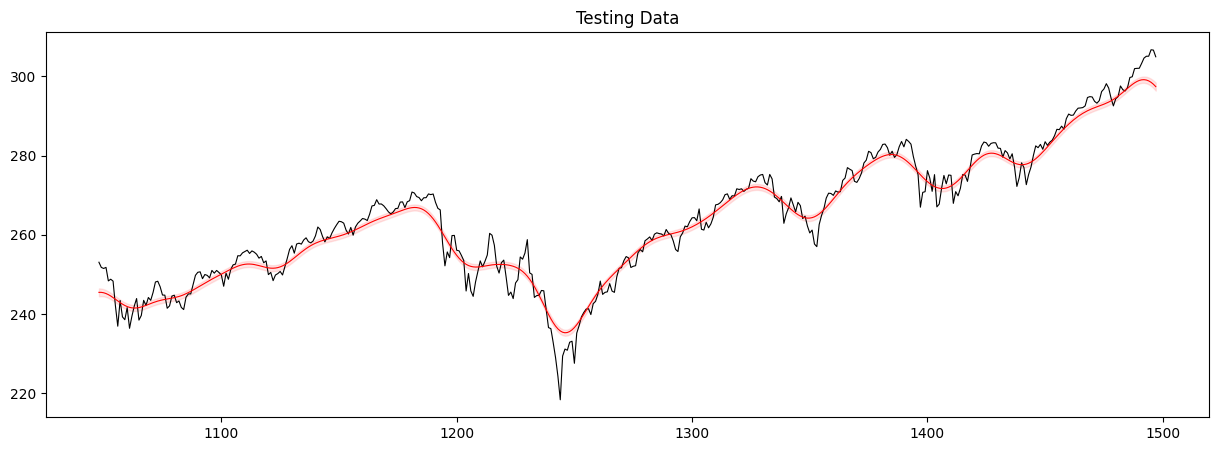

In [12]:
plt.plot(x_test, p_test, color = 'black', lw = 0.8, alpha = 1)
plt.plot(x_test, test_f_preds.mean , color = 'red', lw = 0.8, alpha = 1)
plt.fill_between(x_test, test_f_preds_lower, test_f_preds_upper, color = 'red', alpha=0.1)
plt.title('Testing Data')

**Training Set Fitting**

In [13]:
import matplotlib.figure as figure

def plot_sequential_fit(
    inputs : torch.Tensor,
    targets : torch.Tensor,
    lengthscale : torch.Tensor,
    noise : torch.Tensor,
    weights : torch.Tensor,
    bias : torch.Tensor,
    ) -> List[figure.Figure]:
    """ 
    Constructs a list of plots for sequential fit of a Linear GP model.

    Arguments:
    ----------
    inputs  : {torch.Tensor}
                > x training data to condition on.
    targets : {torch.Tensor}
                > y training data to condition on.
    
    Returns:
    ----------
    figures : {List[figure.Figure]}
                > list of figures.
    """
    # data
    x_star = torch.linspace(inputs[0], inputs[-1], len(inputs)*4)

    # set up figure
    figures = []

    # sequential prediction
    for i in range(len(inputs[:-1])):


        # train points
        target_train_points = targets[:i+1]
        input_train_points = inputs[:i+1]

        # try and fit a GP
        n_gp = get_linear_gp(
                input_train_points, 
                target_train_points, 
                lengthscale, 
                noise,
                weights, 
                bias)
        
        f_preds, lower, upper = n_gp.get_posterior(x_star, True)

        # make plot
        fig = plt.figure()

        plt.plot(input_train_points, target_train_points, marker = 'x', color = 'black', alpha = 1)
        plt.plot(x_star, f_preds.mean, color='red', alpha=1)
        plt.fill_between(x_star, lower, upper, color='red', alpha=.1)

        for i in range(25):
            plt.plot(x_star, f_preds.sample(), color='red', alpha=.1)

        # append figure
        figures.append(fig)

        plt.close()

    return figures

In [14]:

sequential_train_figures = plot_sequential_fit(
                            inputs = x_train[:100],
                            targets = p_train[:100],
                            lengthscale = lengthscal_hat,
                            noise = noise_hat,
                            weights = weights_hat,
                            bias = p_train[0],)

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [17]:
save_to_gif(
    figurelist = sequential_train_figures,
    gifname = 'sequential_fit_train.gif',
    gifduration = 300,
    )

In [18]:
sequential_test_figures = plot_sequential_fit(
                            inputs = x_test[:100],
                            targets = p_test[:100],
                            lengthscale = lengthscal_hat,
                            noise = noise_hat,
                            weights = weights_hat,
                            bias = bias_hat,)

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [19]:
save_to_gif(
    figurelist = sequential_test_figures,
    gifname = 'sequential_fit_test.gif',
    gifduration = 300,
    )

**Prediction GIFs**

In [20]:
def plot_sequential_pred(
    inputs : torch.Tensor,
    targets : torch.Tensor,
    lengthscale : torch.Tensor,
    noise : torch.Tensor,
    weights : torch.Tensor,
    bias : bool = None,
    ) -> List[figure.Figure]:
    """ 
    Constructs a list of plots for sequential prediction of a Linear GP model.

    Arguments:
    ----------
    inputs  : {torch.Tensor}
                > x training data to condition on.
    targets : {torch.Tensor}
                > y training data to condition on.
    lengthscale : {torch.Tensor}
                > lengthscale of the RBF kernel.
    noise : {torch.Tensor}
                > noise of the Gaussian likelihood.
    weights : {torch.Tensor}
                > weights of the linear mean.
    bias : {torch.Tensor}
                > bias of the linear mean.
    
    Returns:
    ----------
    figures : {List[figure.Figure]}
                > list of figures.
    """
    # intercept term
    intercept = targets[0] if bias is None else bias
    
    # set up figure
    figures = []

    # sequential prediction
    for i in range(len(inputs[:-1])):
        
        # test point
        input_test_point = inputs[i].unsqueeze(-1)
        target_test_point = targets[i]
        
        # train points
        input_train_points = inputs[:i]
        target_train_points = targets[:i]

        # fit a GP to ths historica data
        n_gp = get_linear_gp(
                input_train_points, 
                target_train_points, 
                lengthscale, 
                noise,
                weights, 
                intercept)
        
        train_f_preds, train_lower, train_upper = n_gp.get_posterior(input_train_points, True)

        # get predictive
        test_f_preds, test_lower, test_upper = n_gp.get_posterior_predictive(input_test_point, True)

        # make plot
        fig = plt.figure()

        # training
        plt.plot(input_train_points, target_train_points, color = 'black', alpha = 1)
        
        plt.plot(input_train_points, train_f_preds.mean, color='red', alpha=1)
        plt.fill_between(input_train_points, train_lower, train_upper, color='red', alpha=.1)

        # testing
        plt.plot(input_test_point, target_test_point, marker = 'x', color = 'black', alpha = 1)
        plt.plot(input_test_point, test_f_preds.mean, marker = 'x', color = 'steelblue', alpha = 1)
        plt.fill_between(input_test_point, test_lower, test_upper, color='steelblue', alpha=1)

        # append figure
        figures.append(fig)

        plt.close()

    return figures

In [21]:
sequential_pred_train_figures = plot_sequential_pred(
                            inputs = x_train[:100],
                            targets = p_train[:100],
                            lengthscale = lengthscal_hat,
                            noise = noise_hat,
                            weights = weights_hat,
                            bias = p_train[0],)

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [22]:
save_to_gif(
    figurelist = sequential_pred_train_figures,
    gifname = 'sequential_pred_train.gif',
    gifduration = 300,
    )

In [23]:
sequential_pred_test_figures = plot_sequential_pred(
                            inputs = x_test[:100],
                            targets = p_test[:100],
                            lengthscale = lengthscal_hat,
                            noise = noise_hat,
                            weights = weights_hat,
                            bias = bias_hat,)

In [24]:
save_to_gif(
    figurelist = sequential_pred_test_figures,
    gifname = 'sequential_pred_test.gif',
    gifduration = 300,
    )

In [445]:
def get_gp_cross_over_signal(
    X : torch.Tensor,
    P : torch.Tensor,
    lengthscale : torch.Tensor,
    noise : torch.Tensor,
    weights : torch.Tensor,
    bias : torch.Tensor,
    ) -> torch.Tensor:

    # setp
    buy_mask = torch.zeros_like(X)
    sell_mask = torch.zeros_like(X)

    signal = torch.zeros_like(X)   

    # intercept term
    intercept = P[0] if bias is None else bias

    delatas = []
    

    # sequential prediction
    for i, (x, p) in enumerate(zip(X, P)):
        
        if i == 0:
            signal[i] = 0
            continue
        
        # train points
        input_train_points = X[:i]
        target_train_points = P[:i]

        # fit a GP to ths historica data
        n_gp = get_linear_gp(
                input_train_points, 
                target_train_points, 
                lengthscale, 
                noise,
                weights, 
                intercept)

        # get posterior
        train_f_preds, lower, upper = n_gp.get_posterior(input_train_points, True)

        # sell
        if p > upper[-1].item()*1.01:
            signal[i] = -1

        # but
        if p < lower[-1].item()*0.99:
            signal[i] = 1

        else:
            signal[i] = signal[i-1]
    
    return signal, n_gp, lower, upper




In [446]:
# get train test split
split_idx = int(len(df) * 0.7)
risk_free_rate_series = torch.tensor(df['daily_effr'].to_numpy(), dtype=torch.float32)
excess_return_data = torch.tensor(df['daily_excess_returns'].to_numpy(), dtype=torch.float32)
norm_excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_data, test_data = get_train_test_split(splitindex = split_idx, RFR = risk_free_rate_series, daily_R = excess_return_data, norm_R = norm_excess_return_data, P = price_data, X = x_data)

rfr_train, rfr_test = train_data['RFR'], test_data['RFR'] #  risk free rate
daily_r_train, daily_r_test = train_data['daily_R'], test_data['daily_R'] # daily excess returns
norm_r_train, norm_r_test = train_data['norm_R'], test_data['norm_R'] # normalised daily excess returns
p_train, p_test = train_data['P'], test_data['P'] # adjusted closing price
x_train, x_test = train_data['X'], test_data['X'] # x data

In [447]:
train_signal, train_gp, train_lower, train_upper = get_gp_cross_over_signal(
    X = x_train,
    P = p_train,
    lengthscale = lengthscal_hat,
    noise = noise_hat,
    weights = weights_hat,
    bias = p_train[0],
    )

test_signal, test_gp, lower, upper = get_gp_cross_over_signal(
    X = x_test,
    P = p_test,
    lengthscale = lengthscal_hat,
    noise = noise_hat,
    weights = weights_hat,
    bias = bias_hat,)

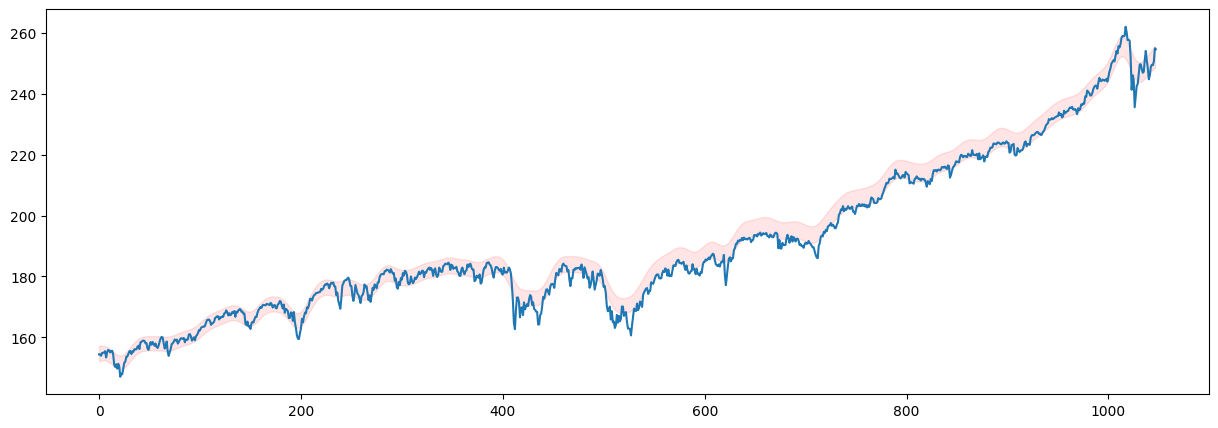

In [455]:
plt.fill_between(x_train[:-1], train_lower*0.99, train_upper*1.01, color='red', alpha=.1)
plt.plot(p_train)

In [459]:
class ConstantGP(gp.models.ExactGP):
    """  GP with Linear Mean """
    
    def __init__(self, inputs, targets, likelihood):
        super(ConstantGP, self).__init__(inputs, targets, likelihood)
        self.mean_module = gp.means.constant_mean.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)
    
    def get_posterior(self, test_inputs, confidenceregion = False):
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            f_preds = self(test_inputs)

        if confidenceregion:
            lower, upper = f_preds.confidence_region()
            return f_preds, lower, upper
        
        return f_preds

    def get_posterior_predictive(self, test_inputs, confidenceregion = False):
        # get posterior
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            observed_pred = self.likelihood(self(test_inputs))

        if confidenceregion:
            lower, upper = observed_pred.confidence_region()
            return observed_pred, lower, upper
        
        return observed_pred

In [689]:
def get_gp_cross_over_signal(
    X : torch.Tensor,
    P : torch.Tensor,
    ) -> torch.Tensor:

    # setp
    buy_mask = torch.zeros_like(X)
    sell_mask = torch.zeros_like(X)

    signal = torch.zeros_like(X)   

    figures = []

    # sequential prediction
    for i, (x, p) in enumerate(zip(X, P)):
        
        window = 25
        
        if i <= window:
            signal[i] = 0
            continue

        # fit a GP to ths historica data
        n_start = i - window
        n_end = i 
        window_gp = ConstantGP(X[n_start:n_end], P[n_start:n_end], gp.likelihoods.GaussianLikelihood())

        window_gp.mean_module.constant = torch.mean(P[n_start:n_end])
        window_gp.covar_module.base_kernel.lengthscale = 2.5
        window_gp.likelihood.noise = .5

        f_preds, lower, upper = window_gp.get_posterior(X[n_start:n_end], True)

        if (p > lower[-1]) and (p < upper[-1]):
            signal[i] = 0
        
        # buy
        elif p >= upper[-1]:
            buy_mask[i] = 1
            signal[i] = p - upper[-1]

        # sell
        elif p <= lower[-1]:
            sell_mask[i] = 1
            signal[i] = p - lower[-1]


    # norm scale the signal
    scaled_signal = signal / torch.std(signal)
    scaled_signal = torch.clamp(scaled_signal, -2, 2)
    
    return scaled_signal/2, buy_mask, sell_mask

In [691]:
train_signal, train_buy_mask, train_sell_mask = get_gp_cross_over_signal(
    X = x_train,
    P = p_train,
    ) 

test_signal, test_buy_mask, test_sell_mask = get_gp_cross_over_signal(
    X = x_test,
    P = p_test,)

# Visualise Strategy

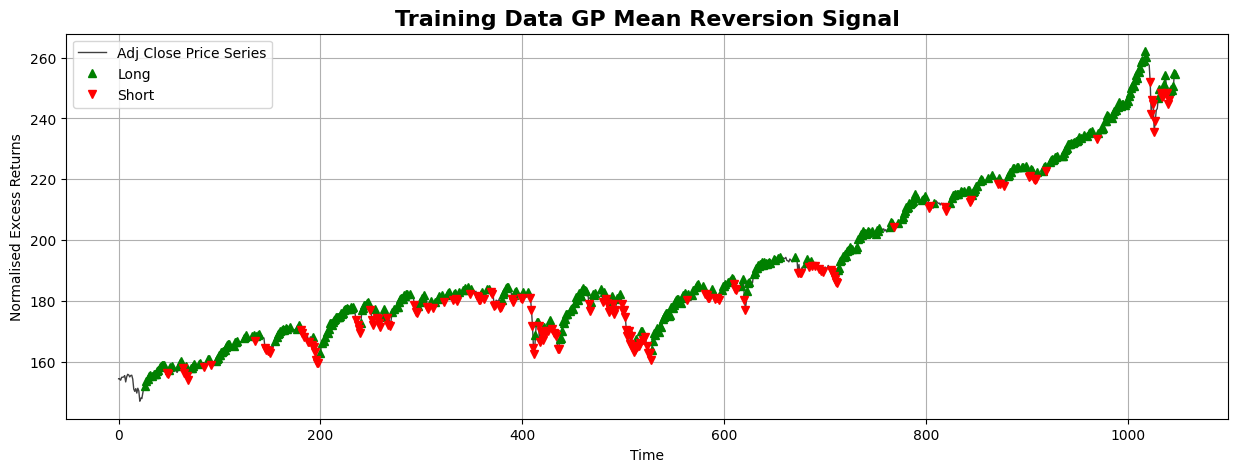

In [693]:
# plot training data
plt.plot(x_train, p_train, 'black', lw = 1, alpha = .75, label = 'Adj Close Price Series')

# plot signals
plt.plot(x_train[train_buy_mask == 1.], p_train[train_buy_mask == 1], 'g^', label = 'Long')
plt.plot(x_train[train_sell_mask == 1], p_train[train_sell_mask == 1], 'rv', label = 'Short')

plt.title('Training Data GP Mean Reversion Signal', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Normalised Excess Returns')
plt.grid(True)
plt.legend()

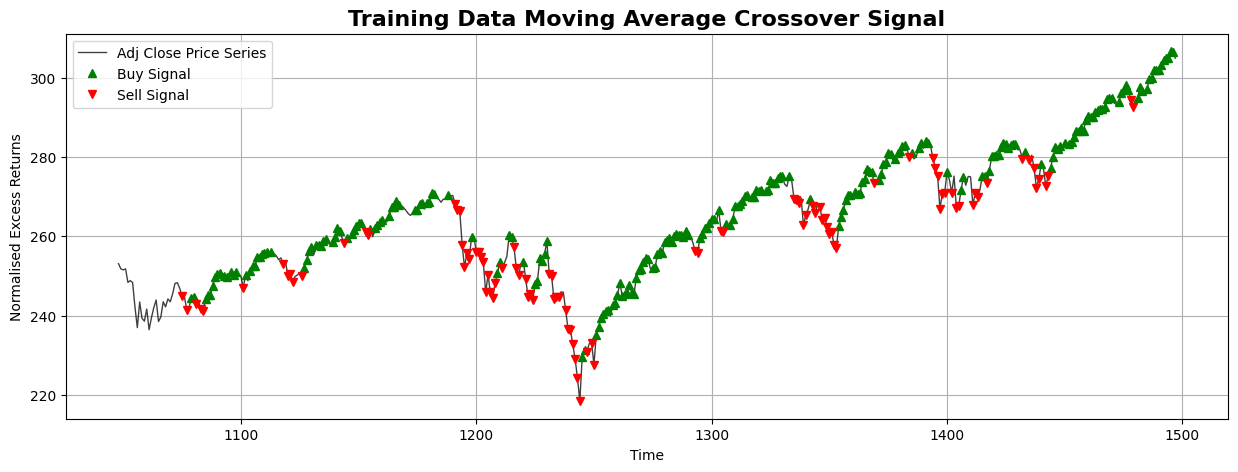

In [694]:
# plot training data
plt.plot(x_test, p_test, 'black', lw = 1, alpha = .75, label = 'Adj Close Price Series')

# plot signals
plt.plot(x_test[test_buy_mask == 1.], p_test[test_buy_mask == 1], 'g^', label = 'Buy Signal')
plt.plot(x_test[test_sell_mask == 1], p_test[test_sell_mask == 1], 'rv', label = 'Sell Signal')

plt.title('Training Data Moving Average Crossover Signal', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Normalised Excess Returns')
plt.grid(True)
plt.legend()

In [702]:
# get dollar values and holdings
train_strategy_data = get_theta_and_V(daily_r_train, rfr_train , train_signal, initial_cash = 200_000., leverage = 5.)
test_strategy_data = get_theta_and_V(daily_r_test, rfr_test , test_signal, initial_cash = 200_000., leverage = 5.)

In [703]:
# unpack training data
train_theta = train_strategy_data['theta']
train_V_t = train_strategy_data['V_t']
train_delta_V_t = train_strategy_data['delta_V_t']
train_V_cap = train_strategy_data['V_cap']
train_delta_V_cap = train_strategy_data['delta_V_cap']
train_V_total = train_strategy_data['V_total']
train_delta_V_total = train_strategy_data['delta_V_total']

# unpack test data
test_theta = test_strategy_data['theta']
test_V_t = test_strategy_data['V_t']
test_delta_V_t = test_strategy_data['delta_V_t']
test_V_cap = test_strategy_data['V_cap']
test_delta_V_cap = test_strategy_data['delta_V_cap']
test_V_total = test_strategy_data['V_total']
test_delta_V_total = test_strategy_data['delta_V_total']

**(b). Plot the position of the strategies θt together with the upper and lower bounds $[−V_t \cdot L, V_t \cdot L]$.**


**Calculate the turnover in dollar value traded over time**

$$ \text{TurnoverDollars} = \sum_{t=0}^T |\Delta \theta_t| $$

**Additionally calculate the turnover in number of units traded over time**

$$ \text{TurnoverUnits} = \sum_{t=0}^T | \frac{\theta_{t+1}}{p_{t+1}} - \frac{\theta_t}{p_t} | $$

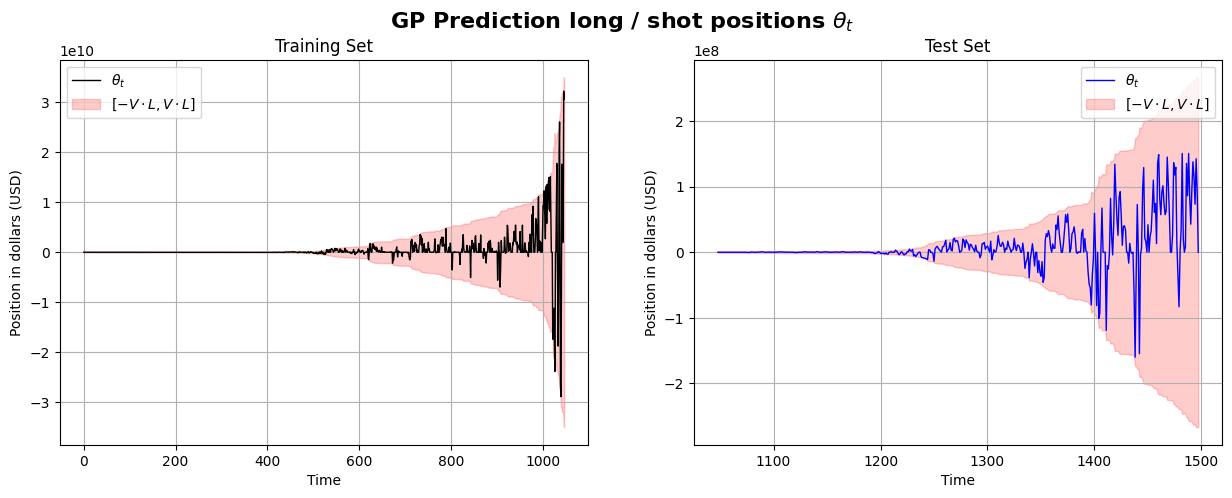

In [704]:
position_fig = plot_strategy_positions(
                    strategy_name = 'GP Prediction',
                    x_train = x_train,
                    train_theta = train_theta,
                    train_V_asset = train_V_t,
                    x_test = x_test,
                    test_theta = test_theta,
                    test_V_asset = test_V_t,)

In [634]:
print('Train Turnover Dollars: ', get_turnover_dollars(train_theta))
print('Train Turnover Units: ', get_turnover_units(train_theta, p_train))
print()
print('Test Turnover Dollars: ', get_turnover_dollars(test_theta))
print('Test Turnover Units: ', get_turnover_units(test_theta, p_test))

Train Turnover Dollars:  21044812603.22754
Train Turnover Units:  94601362.20975001

Test Turnover Dollars:  867683155.890625
Test Turnover Units:  3157287.294019316


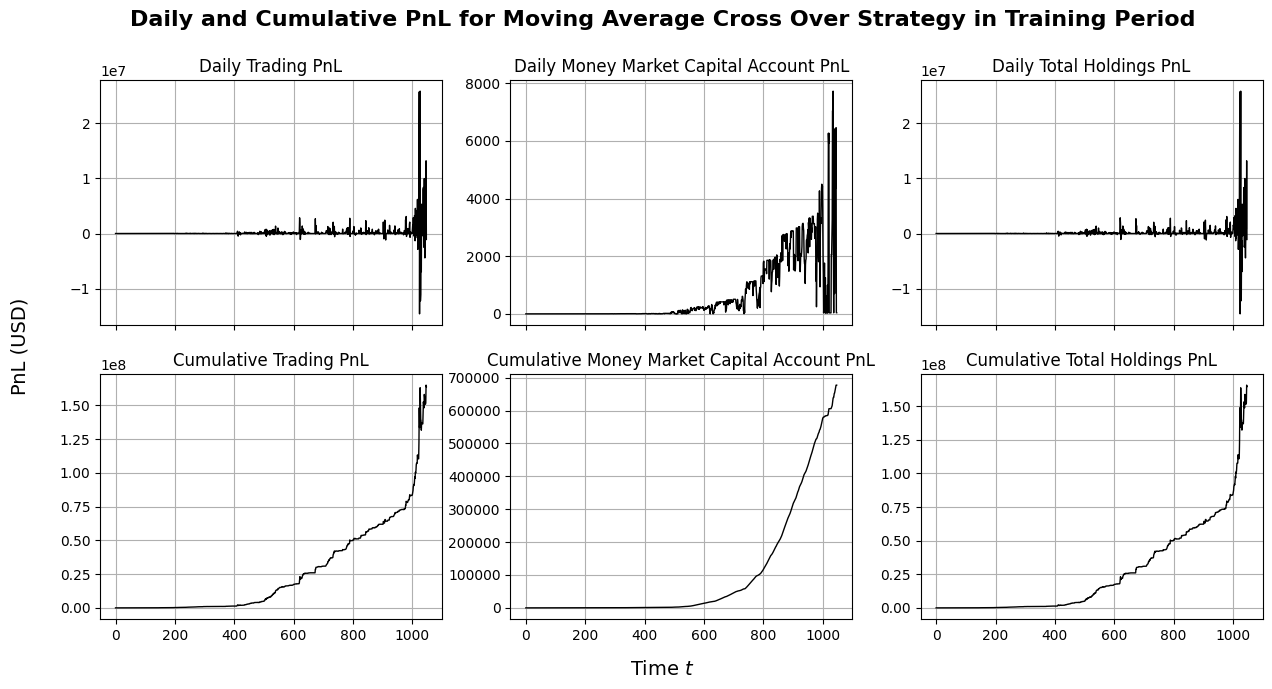

In [635]:
train_pnl_fig = plot_pnl(
    strategy_name = 'Moving Average Cross Over',    
    training_set=True,
    x = x_train,
    delta_V_asset = train_delta_V_t,
    delta_V_cap = train_delta_V_cap,
    delta_V_total = train_delta_V_total,)

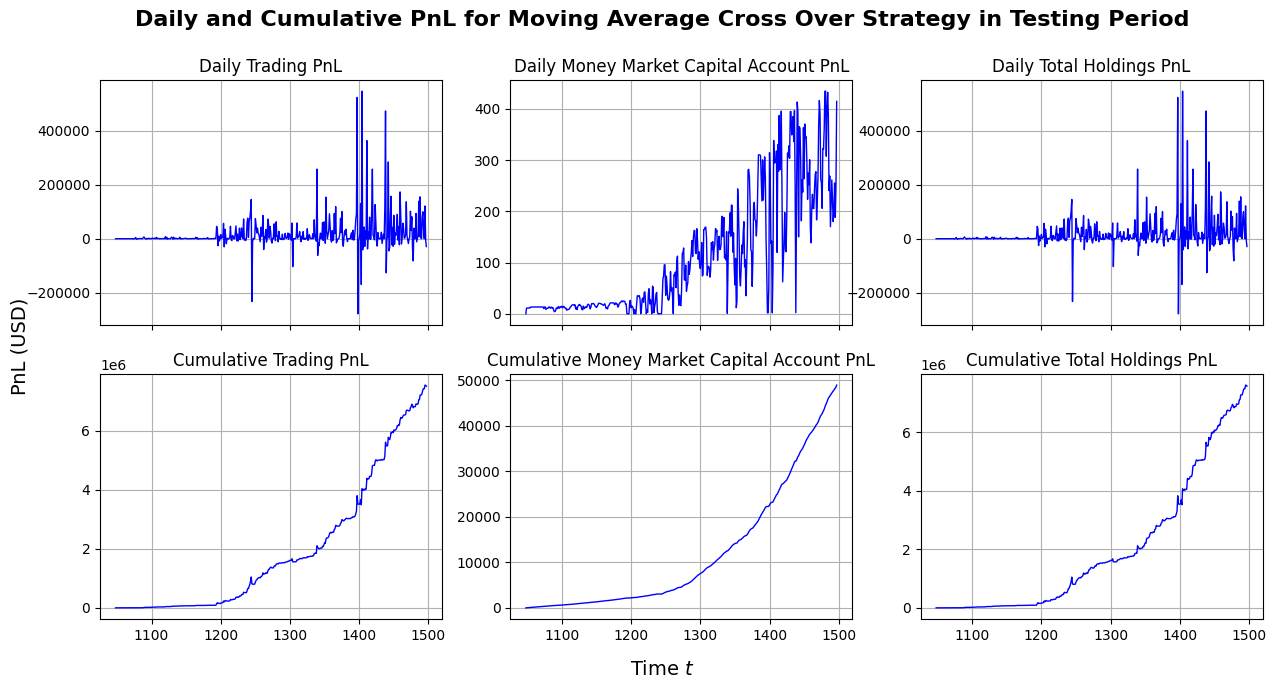

In [636]:
train_pnl_fig = plot_pnl(
    strategy_name = 'Moving Average Cross Over',    
    training_set=False,
    x = x_test,
    delta_V_asset = test_delta_V_t,
    delta_V_cap = test_delta_V_cap,
    delta_V_total = test_delta_V_total,)